# **Dataset - Movielens**

# **Recommendation System 1**

### **Installing necessary packages**

In [ ]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets
!pip install scikit-learn

### **Importing necessary libraries**

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
from sklearn.metrics import precision_score, recall_score, f1_score
from typing import Dict, Text


### **Hybrid Model**

In [ ]:
# Load the ratings and movie features.
ratings = tfds.load('movielens/100k-ratings', split="train")
movies = tfds.load('movielens/100k-movies', split="train")

# Select the basic features.
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"]
})
movies = movies.map(lambda x: x["movie_title"])

# Prepare the vocabulary for user IDs and movie titles.
user_ids_vocabulary = tf.keras.layers.StringLookup(mask_token=None)
user_ids_vocabulary.adapt(ratings.map(lambda x: x["user_id"]))

movie_titles_vocabulary = tf.keras.layers.StringLookup(mask_token=None)
movie_titles_vocabulary.adapt(movies)

# Create user and movie models.
class UserModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.user_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=user_ids_vocabulary.get_vocabulary()),
            tf.keras.layers.Embedding(len(user_ids_vocabulary.get_vocabulary()), 64)  # Increased embedding dimension
        ])

    def call(self, user_id):
        return self.user_embedding(user_id)

class MovieModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.movie_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=movie_titles_vocabulary.get_vocabulary()),
            tf.keras.layers.Embedding(len(movie_titles_vocabulary.get_vocabulary()), 64)  # Increased embedding dimension
        ])

    def call(self, movie_title):
        return self.movie_embedding(movie_title)

# Define the hybrid model.
class HybridModel(tfrs.Model):
    def __init__(self, user_model, movie_model):
        super().__init__()
        self.user_model = user_model
        self.movie_model = movie_model
        self.task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(
            candidates=movies.batch(128).map(self.movie_model)
        ))

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        user_embeddings = self.user_model(features["user_id"])
        movie_embeddings = self.movie_model(features["movie_title"])

        return self.task(user_embeddings, movie_embeddings)

user_model = UserModel()
movie_model = MovieModel()

model = HybridModel(user_model, movie_model)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/movielens/100k-ratings/incomplete.EXXBE3_0.1.1/movielens-train.tfrecord*..…

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-ratings/0.1.1. Subsequent calls will reuse this data.


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1682 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/movielens/100k-movies/incomplete.1ZMGOV_0.1.1/movielens-train.tfrecord*...…

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-movies/0.1.1. Subsequent calls will reuse this data.


### **Train & Evaluate The Model**

In [ ]:
# Train the model.
cached_ratings = ratings.shuffle(100_000).batch(8192).cache()
model.fit(cached_ratings, epochs=10)  # Increased number of epochs

# Evaluate the model.
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
index.index_from_dataset(
    movies.batch(100).map(lambda title: (title, model.movie_model(title)))
)

# Make some recommendations.
_, titles = index(tf.constant(["42"]))
print(f"Top 3 recommendations for user 42: {titles[0, :3]}")


Epoch 1/10
13/13 [==============================] - 57s 4s/step - factorized_top_k/top_1_categorical_accuracy: 8.3000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0087 - factorized_top_k/top_10_categorical_accuracy: 0.0200 - factorized_top_k/top_50_categorical_accuracy: 0.1084 - factorized_top_k/top_100_categorical_accuracy: 0.1955 - loss: 64173.6981 - regularization_loss: 0.0000e+00 - total_loss: 64173.6981
Epoch 2/10
13/13 [==============================] - 45s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0022 - factorized_top_k/top_5_categorical_accuracy: 0.0163 - factorized_top_k/top_10_categorical_accuracy: 0.0349 - factorized_top_k/top_50_categorical_accuracy: 0.1646 - factorized_top_k/top_100_categorical_accuracy: 0.2903 - loss: 61782.2266 - regularization_loss: 0.0000e+00 - total_loss: 61782.2266
Epoch 3/10
13/13 [==============================] - 42s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0022 - factorized_top_k/top_5_categorical_accuracy:

In [14]:
# Function to get recommendations based on input movie.
def get_recommendations(input_movie, index, model):
    input_title = tf.constant([input_movie])
    _, titles = index(input_title)
    return titles.numpy()[0]

# Example: Interactive input and recommendations.
while True:
    input_movie = input("Enter a movie title (or 'exit' to quit): ")
    if input_movie.lower() == 'exit':
        break
    recommended_movies = get_recommendations(input_movie, index, model)
    print(f"Top 3 recommendations for '{input_movie}': {recommended_movies[:3]}")


Enter a movie title (or 'exit' to quit): Titanic
Top 3 recommendations for 'Titanic': [b'Nina Takes a Lover (1994)' b'Red Firecracker, Green Firecracker (1994)'
 b'Flirt (1995)']
Enter a movie title (or 'exit' to quit): exit


In [10]:
# Convert the datasets to a unique list of movie titles and user IDs
unique_movie_titles = []
unique_user_ids = []

# Convert movies to a list
for movie in movies:
    unique_movie_titles.append(movie.numpy().decode('utf-8'))

# Convert user_ids to a list
for rating in ratings:
    unique_user_ids.append(rating['user_id'].numpy().decode('utf-8'))

# Remove duplicates
unique_movie_titles = list(set(unique_movie_titles))
unique_user_ids = list(set(unique_user_ids))

print("Unique movie titles:", unique_movie_titles[:5])  # Show a few examples
print("Unique user IDs:", unique_user_ids[:5])          # Show a few examples

# Ensure the lengths are correct
print(f"Number of unique movie titles: {len(unique_movie_titles)}")
print(f"Number of unique user IDs: {len(unique_user_ids)}")

Unique movie titles: ['To Be or Not to Be (1942)', 'Farewell to Arms, A (1932)', 'Rough Magic (1995)', 'Hearts and Minds (1996)', 'Swimming with Sharks (1995)']
Unique user IDs: ['803', '370', '424', '866', '437']
Number of unique movie titles: 1664
Number of unique user IDs: 943


### **Recommended movies for user**

In [11]:
def get_movie_recommendations(user_id, model, movie_titles, top_k=6):
    user_embedding = model.user_model(tf.constant([user_id]))
    movie_embeddings = model.movie_model(tf.constant(movie_titles))

    scores = tf.matmul(user_embedding, movie_embeddings, transpose_b=True).numpy().flatten()
    top_indices = np.argsort(scores)[-top_k:][::-1]
    return [movie_titles[i] for i in top_indices]

# Example: Get recommendations for a specific user ID
user_id_example = "42"  # Replace with a valid user ID from your data
recommended_movies = get_movie_recommendations(user_id_example, model, unique_movie_titles)

# Print the recommendations
print(f"Recommended Movies for User ID {user_id_example}:")
for idx, movie in enumerate(recommended_movies, 1):
    print(f"{idx}. {movie}")


Recommended Movies for User ID 42:
1. Rent-a-Kid (1995)
2. Land Before Time III: The Time of the Great Giving (1995) (V)
3. Two if by Sea (1996)
4. Murder in the First (1995)
5. Unstrung Heroes (1995)
6. Winnie the Pooh and the Blustery Day (1968)


### **Recommended movies based on similar movies**

In [12]:
def recommend_similar_movies(movie_title, model, movie_titles, top_k=8):
    movie_embedding = model.movie_model(tf.constant([movie_title]))
    all_movie_embeddings = model.movie_model(tf.constant(movie_titles))

    scores = tf.matmul(movie_embedding, all_movie_embeddings, transpose_b=True).numpy().flatten()
    top_indices = np.argsort(scores)[-top_k:][::-1]
    return [movie_titles[i] for i in top_indices]

# Example: Recommend movies similar to "Toy Story (1995)"
movie_example = "Titanic"  # Replace with a valid movie title from your data
similar_movies = recommend_similar_movies(movie_example, model, unique_movie_titles)

# Print similar movies
print(f"Movies similar to '{movie_example}':")
for idx, movie in enumerate(similar_movies, 1):
    print(f"{idx}. {movie}")


Movies similar to 'Titanic':
1. Roman Holiday (1953)
2. Life Less Ordinary, A (1997)
3. Peacemaker, The (1997)
4. 'Til There Was You (1997)
5. Wild Bill (1995)
6. Ruby in Paradise (1993)
7. Wedding Singer, The (1998)
8. Somewhere in Time (1980)


# **Recommendation System 2**

### **Importing necessary libraries**

In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import keras
from pprint import pprint

### **Loading dataset**

In [16]:
DATASET_LINK='http://files.grouplens.org/datasets/movielens/ml-100k.zip'
!wget -nc http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -n ml-100k.zip

--2024-07-03 12:18:26--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  24.1MB/s    in 0.2s    

2024-07-03 12:18:26 (24.1 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base

In [17]:
overall_stats = pd.read_csv('ml-100k/u.info', header=None)
print("Details of users, items and ratings involved in the loaded movielens dataset: ",list(overall_stats[0]))

Details of users, items and ratings involved in the loaded movielens dataset:  ['943 users', '1682 items', '100000 ratings']


In [18]:
column_names1 = ['user id','movie id','rating','timestamp']
ratings_dataset = pd.read_csv('ml-100k/u.data', sep='\t',header=None,names=column_names1)
print(ratings_dataset.head())
d = 'movie id | movie title | release date | video release date | IMDb URL | unknown | Action | Adventure | Animation | Children | Comedy | Crime | Documentary | Drama | Fantasy | Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi | Thriller | War | Western'
column_names2 = d.split(' | ')
print(column_names2)

   user id  movie id  rating  timestamp
0      196       242       3  881250949
1      186       302       3  891717742
2       22       377       1  878887116
3      244        51       2  880606923
4      166       346       1  886397596
['movie id', 'movie title', 'release date', 'video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


In [19]:
items_dataset = pd.read_csv('ml-100k/u.item', sep='|',header=None,names=column_names2,encoding='latin-1')
items_dataset.head()

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [20]:
movie_dataset = items_dataset[['movie id','movie title']]
movie_dataset.head()
merged_dataset = pd.merge(ratings_dataset, movie_dataset, how='inner', on='movie id')
merged_dataset.head()
merged_dataset[(merged_dataset['movie title'] == 'Chasing Amy (1997)') & (merged_dataset['user id'] == 894)]
refined_dataset = merged_dataset.groupby(by=['user id','movie title'], as_index=False).agg({"rating":"mean"})

refined_dataset.head()


,user id,movie title,rating
0,1,101 Dalmatians (1996),2.0
1,1,12 Angry Men (1957),5.0
2,1,"20,000 Leagues Under the Sea (1954)",3.0
3,1,2001: A Space Odyssey (1968),4.0
4,1,"Abyss, The (1989)",3.0


from matplotlib import pyplot as plt
_df_0['rating'].plot(kind='hist', bins=20, title='rating')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('movie title').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['user id']
  ys = series['rating']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_2.sort_values('user id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('movie title')):
  _plot_series(series, series_name, i)
  fig.legend(title='movie title', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('user id')
_ = plt.ylabel('rating')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['user id']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'user id'}, axis=1)
              .sort_values('user id', ascending=True))
  xs = counted['user id']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('user id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('movie title')):
  _plot_series(series, series_name, i)
  fig.legend(title='movie title', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('user id')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_4['rating'].plot(kind='line', figsize=(8, 4), title='rating')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_5['movie title'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_5, x='rating', y='movie title', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [23]:
user_enc = LabelEncoder()
refined_dataset['user'] = user_enc.fit_transform(refined_dataset['user id'].values)
n_users = refined_dataset['user'].nunique()

item_enc = LabelEncoder()
refined_dataset['movie'] = item_enc.fit_transform(refined_dataset['movie title'].values)
n_movies = refined_dataset['movie'].nunique()

In [24]:
refined_dataset['rating'] = refined_dataset['rating'].values.astype(np.float32)
min_rating = min(refined_dataset['rating'])
max_rating = max(refined_dataset['rating'])
n_users, n_movies, min_rating, max_rating

(943, 1664, 1.0, 5.0)

In [25]:
refined_dataset.head()

,user id,movie title,rating,user,movie
0,1,101 Dalmatians (1996),2.0,0,2
1,1,12 Angry Men (1957),5.0,0,3
2,1,"20,000 Leagues Under the Sea (1954)",3.0,0,6
3,1,2001: A Space Odyssey (1968),4.0,0,7
4,1,"Abyss, The (1989)",3.0,0,16


from matplotlib import pyplot as plt
_df_6['rating'].plot(kind='hist', bins=20, title='rating')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7['movie'].plot(kind='hist', bins=20, title='movie')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_8.groupby('movie title').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9.plot(kind='scatter', x='rating', y='movie', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['user id']
  ys = series['rating']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('user id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('movie title')):
  _plot_series(series, series_name, i)
  fig.legend(title='movie title', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('user id')
_ = plt.ylabel('rating')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['user id']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'user id'}, axis=1)
              .sort_values('user id', ascending=True))
  xs = counted['user id']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('user id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('movie title')):
  _plot_series(series, series_name, i)
  fig.legend(title='movie title', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('user id')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['user']
  ys = series['rating']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('user', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('movie title')):
  _plot_series(series, series_name, i)
  fig.legend(title='movie title', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('user')
_ = plt.ylabel('rating')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['user']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'user'}, axis=1)
              .sort_values('user', ascending=True))
  xs = counted['user']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_13.sort_values('user', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('movie title')):
  _plot_series(series, series_name, i)
  fig.legend(title='movie title', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('user')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_14['rating'].plot(kind='line', figsize=(8, 4), title='rating')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['movie'].plot(kind='line', figsize=(8, 4), title='movie')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_16['movie title'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_16, x='rating', y='movie title', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['movie title'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='movie', y='movie title', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [26]:
X = refined_dataset[['user', 'movie']].values
y = refined_dataset['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=50)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((89723, 2), (9970, 2), (89723,), (9970,))

In [27]:
n_factors = 150

In [28]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]
X_train, X_train_array, X_train_array[0].shape

(array([[ 180, 1152],
        [ 487,  389],
        [ 177,  302],
        ...,
        [ 431, 1588],
        [ 232,  399],
        [ 138,  612]]),
 [array([180, 487, 177, ..., 431, 232, 138]),
  array([1152,  389,  302, ..., 1588,  399,  612])],
 (89723,))

In [29]:
y_train = (y_train - min_rating)/(max_rating - min_rating)
y_test = (y_test - min_rating)/(max_rating - min_rating)

### **Softmax Deep Neural Network Model**

In [31]:
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers import Concatenate, Dense, Dropout
from keras.layers import Add, Activation, Lambda

## Initializing a input layer for users
user = tf.keras.layers.Input(shape = (1,))

# Use tf.keras.layers.Embedding instead of keras.layers.embeddings.Embedding
u = tf.keras.layers.Embedding(n_users, n_factors, embeddings_initializer = 'he_normal', embeddings_regularizer = tf.keras.regularizers.l2(1e-6))(user)
u = tf.keras.layers.Reshape((n_factors,))(u)

## Initializing a input layer for movies
movie = tf.keras.layers.Input(shape = (1,))

## Embedding layer for n_factors of movies
# Use tf.keras.layers.Embedding instead of keras.layers.embeddings.Embedding
m = tf.keras.layers.Embedding(n_movies, n_factors, embeddings_initializer = 'he_normal', embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(movie)
m = tf.keras.layers.Reshape((n_factors,))(m)

## stacking up both user and movie embeddings
x = tf.keras.layers.Concatenate()([u,m])
x = tf.keras.layers.Dropout(0.05)(x)

## Adding a Dense layer to the architecture
x = tf.keras.layers.Dense(32, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

x = tf.keras.layers.Dense(16, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

## Adding an Output layer with Sigmoid activation funtion which gives output between 0 and 1
x = tf.keras.layers.Dense(9)(x)
x = tf.keras.layers.Activation(activation='softmax')(x)

## Adding a Lambda layer to convert the output to rating by scaling it with the help of available rating information
# x = tf.keras.layers.Lambda(lambda x: x*(max_rating - min_rating) + min_rating)(x)

## Defining the model
model = tf.keras.models.Model(inputs=[user,movie], outputs=x)

model.compile(optimizer='sgd', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [32]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_4 (Embedding)     (None, 1, 150)               141450    ['input_3[0][0]']             
                                                                                                  
 embedding_5 (Embedding)     (None, 1, 150)               249600    ['input_4[0][0]']             
                                                                                            

### **Training & Evaluating**

In [33]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=3, min_lr=0.000001, verbose=1)

history = model.fit(x = X_train_array, y = y_train, batch_size=128, epochs=70, verbose=1, validation_data=(X_test_array, y_test)
,shuffle=True,callbacks=[reduce_lr])


Epoch 1/70
701/701 [==============================] - 6s 7ms/step - loss: 0.8129 - accuracy: 0.0609 - val_loss: 0.5275 - val_accuracy: 0.0617 - lr: 0.0100
Epoch 2/70
701/701 [==============================] - 5s 7ms/step - loss: 0.5347 - accuracy: 0.0609 - val_loss: 0.5151 - val_accuracy: 0.0617 - lr: 0.0100
Epoch 3/70
701/701 [==============================] - 8s 11ms/step - loss: 0.5266 - accuracy: 0.0609 - val_loss: 0.5125 - val_accuracy: 0.0617 - lr: 0.0100
Epoch 4/70
701/701 [==============================] - 4s 6ms/step - loss: 0.5235 - accuracy: 0.0609 - val_loss: 0.5115 - val_accuracy: 0.0617 - lr: 0.0100
Epoch 5/70
701/701 [==============================] - 4s 6ms/step - loss: 0.5219 - accuracy: 0.0609 - val_loss: 0.5113 - val_accuracy: 0.0617 - lr: 0.0100
Epoch 6/70
701/701 [==============================] - 6s 9ms/step - loss: 0.5211 - accuracy: 0.0609 - val_loss: 0.5106 - val_accuracy: 0.0617 - lr: 0.0100
Epoch 7/70
701/701 [==============================] - 6s 9ms/step - l

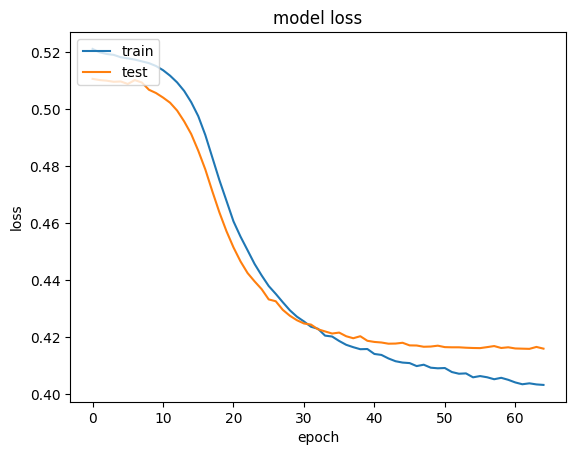

In [34]:
plt.plot(history.history["loss"][5:])
plt.plot(history.history["val_loss"][5:])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [35]:
refined_dataset.head()

,user id,movie title,rating,user,movie
0,1,101 Dalmatians (1996),2.0,0,2
1,1,12 Angry Men (1957),5.0,0,3
2,1,"20,000 Leagues Under the Sea (1954)",3.0,0,6
3,1,2001: A Space Odyssey (1968),4.0,0,7
4,1,"Abyss, The (1989)",3.0,0,16


from matplotlib import pyplot as plt
_df_18['rating'].plot(kind='hist', bins=20, title='rating')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_19['movie'].plot(kind='hist', bins=20, title='movie')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_20.groupby('movie title').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_21.plot(kind='scatter', x='rating', y='movie', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['user id']
  ys = series['rating']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_22.sort_values('user id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('movie title')):
  _plot_series(series, series_name, i)
  fig.legend(title='movie title', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('user id')
_ = plt.ylabel('rating')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['user id']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'user id'}, axis=1)
              .sort_values('user id', ascending=True))
  xs = counted['user id']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_23.sort_values('user id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('movie title')):
  _plot_series(series, series_name, i)
  fig.legend(title='movie title', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('user id')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['user']
  ys = series['rating']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_24.sort_values('user', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('movie title')):
  _plot_series(series, series_name, i)
  fig.legend(title='movie title', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('user')
_ = plt.ylabel('rating')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['user']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'user'}, axis=1)
              .sort_values('user', ascending=True))
  xs = counted['user']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_25.sort_values('user', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('movie title')):
  _plot_series(series, series_name, i)
  fig.legend(title='movie title', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('user')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_26['rating'].plot(kind='line', figsize=(8, 4), title='rating')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_27['movie'].plot(kind='line', figsize=(8, 4), title='movie')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_28['movie title'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_28, x='rating', y='movie title', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_29['movie title'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_29, x='movie', y='movie title', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [36]:
X_train_array

[array([180, 487, 177, ..., 431, 232, 138]),
 array([1152,  389,  302, ..., 1588,  399,  612])]

In [37]:
user_id = [777]
encoded_user_id = user_enc.transform(user_id)

seen_movies = list(refined_dataset[refined_dataset['user id'] == user_id[0]]['movie'])
print(seen_movies)

[7, 55, 87, 113, 313, 337, 389, 390, 399, 411, 432, 460, 498, 528, 580, 604, 612, 643, 666, 783, 996, 1005, 1032, 1102, 1132, 1157, 1190, 1208, 1251, 1260, 1284, 1302, 1342, 1523, 1558, 1615]


In [38]:
len(refined_dataset['movie'].unique()), min(refined_dataset['movie']), max(refined_dataset['movie'])

(1664, 0, 1663)

In [39]:
unseen_movies = [i for i in range(min(refined_dataset['movie']), max(refined_dataset['movie'])+1) if i not in seen_movies]
print(unseen_movies)

[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 

In [40]:
len(unseen_movies) + len(seen_movies)

1664

In [41]:
model_input = [np.asarray(list(encoded_user_id)*len(unseen_movies)), np.asarray(unseen_movies)]
len(model_input), len(model_input[0])

(2, 1628)

In [42]:
predicted_ratings = model.predict(model_input)

51/51 [==============================] - 0s 3ms/step


In [43]:
print(predicted_ratings.shape)

(1628, 9)


In [44]:
print(predicted_ratings)

[[7.0179576e-01 2.9812101e-01 8.1047610e-06 ... 1.7272423e-05
  9.9805748e-06 9.1936063e-06]
 [6.6840696e-01 3.3151114e-01 7.7226641e-06 ... 1.6526728e-05
  9.2250039e-06 8.6914579e-06]
 [8.6830574e-01 1.3165905e-01 3.2380999e-06 ... 7.9553738e-06
  4.5562788e-06 3.6978536e-06]
 ...
 [7.1131307e-01 2.8863248e-01 5.0601893e-06 ... 1.0911585e-05
  6.4044730e-06 5.7551802e-06]
 [6.0736835e-01 3.9253676e-01 8.8450697e-06 ... 1.7934452e-05
  1.0820238e-05 1.0186382e-05]
 [5.8131820e-01 4.1859159e-01 8.1663011e-06 ... 1.7799422e-05
  9.8155269e-06 9.5731111e-06]]


In [45]:
predicted_ratings = np.max(predicted_ratings, axis=1)
predicted_ratings

array([0.70179576, 0.66840696, 0.86830574, ..., 0.71131307, 0.60736835,
       0.5813182 ], dtype=float32)

In [46]:
predicted_ratings.shape

(1628,)

In [47]:
sorted_index = np.argsort(predicted_ratings)[::-1]
print(sorted_index)


[ 135 1445  621 ...  463 1382  456]


In [48]:
recommended_movies = item_enc.inverse_transform(sorted_index)
recommended_movies


array(['Baton Rouge (1988)', 'Sword in the Stone, The (1963)',
       'Good Will Hunting (1997)', ..., 'Eraser (1996)', 'Squeeze (1996)',
       'Empire Strikes Back, The (1980)'], dtype=object)

In [49]:
from pprint import pprint
pprint(list(recommended_movies[:20]))


['Baton Rouge (1988)',
 'Sword in the Stone, The (1963)',
 'Good Will Hunting (1997)',
 'Saint, The (1997)',
 'Meet Wally Sparks (1997)',
 'Conspiracy Theory (1997)',
 'Grosse Fatigue (1994)',
 'Circle of Friends (1995)',
 'Month by the Lake, A (1995)',
 'Even Cowgirls Get the Blues (1993)',
 'Bonnie and Clyde (1967)',
 'Striking Distance (1993)',
 'Red Firecracker, Green Firecracker (1994)',
 'Jaws 2 (1978)',
 'Two or Three Things I Know About Her (1966)',
 'Bride of Frankenstein (1935)',
 'In the Line of Duty 2 (1987)',
 'Basic Instinct (1992)',
 'Phat Beach (1996)',
 'This Is Spinal Tap (1984)']


In [51]:
def recommender_system(user_id, model, n_movies):

  print("")
  print("Movie seen by the User:")
  pprint(list(refined_dataset[refined_dataset['user id'] == user_id]['movie title']))
  print("")

  encoded_user_id = user_enc.transform([user_id])

  seen_movies = list(refined_dataset[refined_dataset['user id'] == user_id]['movie'])
  unseen_movies = [i for i in range(min(refined_dataset['movie']), max(refined_dataset['movie'])+1) if i not in seen_movies]
  model_input = [np.asarray(list(encoded_user_id)*len(unseen_movies)), np.asarray(unseen_movies)]
  predicted_ratings = model.predict(model_input)
  predicted_ratings = np.max(predicted_ratings, axis=1)
  sorted_index = np.argsort(predicted_ratings)[::-1]
  recommended_movies = item_enc.inverse_transform(sorted_index)
  print("---------------------------------------------------------------------------------")
  print("Top "+str(n_movies)+" Movie recommendations for the User "+str(user_id)+ " are:")
  pprint(list(recommended_movies[:n_movies]))

In [52]:
print("Enter user id")
user_id= int(input())

print("Enter number of movies to be recommended:")
n_movies = int(input())
recommender_system(user_id,model,n_movies)


Enter user id
27
Enter number of movies to be recommended:
4

Movie seen by the User:
['Boot, Das (1981)',
 'Breakdown (1997)',
 'Chain Reaction (1996)',
 'Chasing Amy (1997)',
 'Crash (1996)',
 'Dead Man Walking (1995)',
 'English Patient, The (1996)',
 'Face/Off (1997)',
 'Fargo (1996)',
 'Frighteners, The (1996)',
 'Ghost and the Darkness, The (1996)',
 "Heaven's Prisoners (1996)",
 'Hunchback of Notre Dame, The (1996)',
 'Independence Day (ID4) (1996)',
 'Mary Reilly (1996)',
 'People vs. Larry Flynt, The (1996)',
 'Ransom (1996)',
 'River Wild, The (1994)',
 'Scream (1996)',
 "Smilla's Sense of Snow (1997)",
 'Star Wars (1977)',
 'Trainspotting (1996)',
 'Trees Lounge (1996)',
 'Twister (1996)',
 'Unforgettable (1996)']

52/52 [==============================] - 0s 2ms/step
---------------------------------------------------------------------------------
Top 4 Movie recommendations for the User 27 are:
['Beautician and the Beast, The (1997)',
 'Screamers (1995)',
 'Cronos (1992)',


# **Recommendation System 3**

### **Importing necessary libraries**

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
!pip install fuzzywuzzy
from fuzzywuzzy import process

### **Loading dataset**

In [2]:
ratings = pd.read_csv('/content/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1.147880e+09
1,1,306,3.5,1.147869e+09
2,1,307,5.0,1.147869e+09
3,1,665,5.0,1.147879e+09
4,1,899,3.5,1.147869e+09


from matplotlib import pyplot as plt
_df_0['movieId'].plot(kind='hist', bins=20, title='movieId')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['rating'].plot(kind='hist', bins=20, title='rating')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['timestamp'].plot(kind='hist', bins=20, title='timestamp')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='movieId', y='rating', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='rating', y='timestamp', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['userId']
  ys = series['rating']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('userId', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('userId')
_ = plt.ylabel('rating')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['userId']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'userId'}, axis=1)
              .sort_values('userId', ascending=True))
  xs = counted['userId']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('userId', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('userId')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['movieId']
  ys = series['rating']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('movieId', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('movieId')
_ = plt.ylabel('rating')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['movieId']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'movieId'}, axis=1)
              .sort_values('movieId', ascending=True))
  xs = counted['movieId']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('movieId', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('movieId')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_9['movieId'].plot(kind='line', figsize=(8, 4), title='movieId')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['rating'].plot(kind='line', figsize=(8, 4), title='rating')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['timestamp'].plot(kind='line', figsize=(8, 4), title='timestamp')
plt.gca().spines[['top', 'right']].set_visible(False)

In [3]:
movies = pd.read_csv("/content/movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


from matplotlib import pyplot as plt
_df_12['movieId'].plot(kind='hist', bins=20, title='movieId')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_13.groupby('title').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_14.groupby('genres').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['movieId']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'movieId'}, axis=1)
              .sort_values('movieId', ascending=True))
  xs = counted['movieId']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_15.sort_values('movieId', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('title')):
  _plot_series(series, series_name, i)
  fig.legend(title='title', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('movieId')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['movieId']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'movieId'}, axis=1)
              .sort_values('movieId', ascending=True))
  xs = counted['movieId']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_16.sort_values('movieId', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('genres')):
  _plot_series(series, series_name, i)
  fig.legend(title='genres', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('movieId')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_17['movieId'].plot(kind='line', figsize=(8, 4), title='movieId')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['genres'].value_counts()
    for x_label, grp in _df_18.groupby('title')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('title')
_ = plt.ylabel('genres')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['title'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='movieId', y='title', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['genres'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='movieId', y='genres', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [4]:
unique_user = ratings.userId.nunique(dropna = True)
unique_movie = ratings.movieId.nunique(dropna = True)
print("number of unique user:")
print(unique_user)
print("number of unique movies:")
print(unique_movie)

number of unique user:
1203
number of unique movies:
12243


In [5]:
# for creating item user matrix  .. we need to check how many ratings we have here or how many are absent .
total_ratings = unique_user*unique_movie
rating_present = ratings.shape[0]

ratings_not_provided = total_ratings - rating_present

print("ratings not provided means some user have not watched some movies and its given by")
print(ratings_not_provided)
print("sparsity of user-item matrix is :")
print(ratings_not_provided / total_ratings)

ratings not provided means some user have not watched some movies and its given by
14559120
sparsity of user-item matrix is :
0.9885113239933736


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


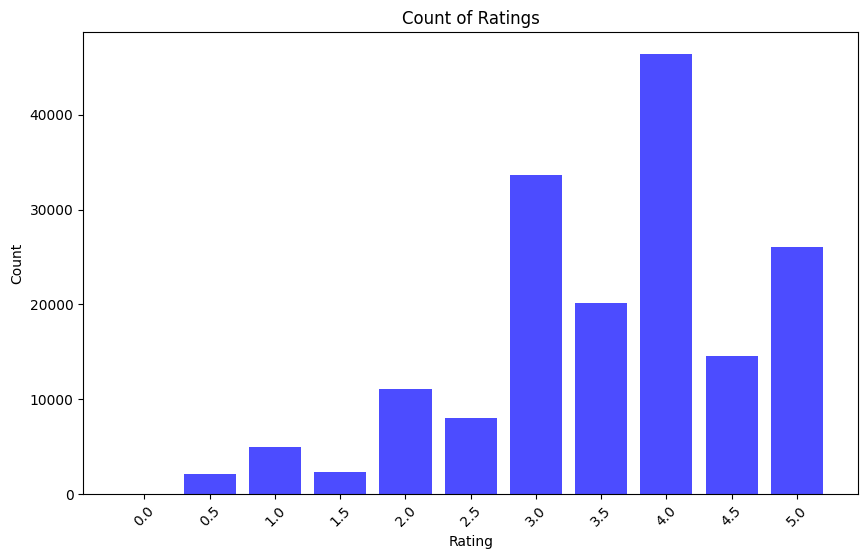

        count  log_count
rating                  
0.0         0       -inf
0.5      2097   7.648263
1.0      4943   8.505728
1.5      2342   7.758761
2.0     11096   9.314340
2.5      7999   8.987072
3.0     33592  10.422043
3.5     20169   9.911902
4.0     46364  10.744279
4.5     14600   9.588777
5.0     26007  10.166121


In [6]:
rating_cnt = pd.DataFrame(ratings.groupby('rating').size(), columns=['count'])

# Add count for rating 0 if it doesn't exist
if 0 not in rating_cnt.index:
    rating_cnt.loc[0] = 0

# Sort by index
rating_cnt = rating_cnt.sort_index()

# Calculate log of counts
rating_cnt['log_count'] = np.log(rating_cnt['count'])

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(rating_cnt.index.astype(str), rating_cnt['count'], color='blue', alpha=0.7)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Count of Ratings')
plt.xticks(rotation=45)
plt.show()
print(rating_cnt)

In [7]:

movie_freq = pd.DataFrame(ratings.groupby('movieId').size(),columns=['count'])
movie_freq.head()

,count
movieId,
1,414
2,146
3,95
4,13
5,95


from matplotlib import pyplot as plt
_df_21['count'].plot(kind='hist', bins=20, title='count')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_22['count'].plot(kind='line', figsize=(8, 4), title='count')
plt.gca().spines[['top', 'right']].set_visible(False)

Text(0, 0.5, 'rating freq of movies')

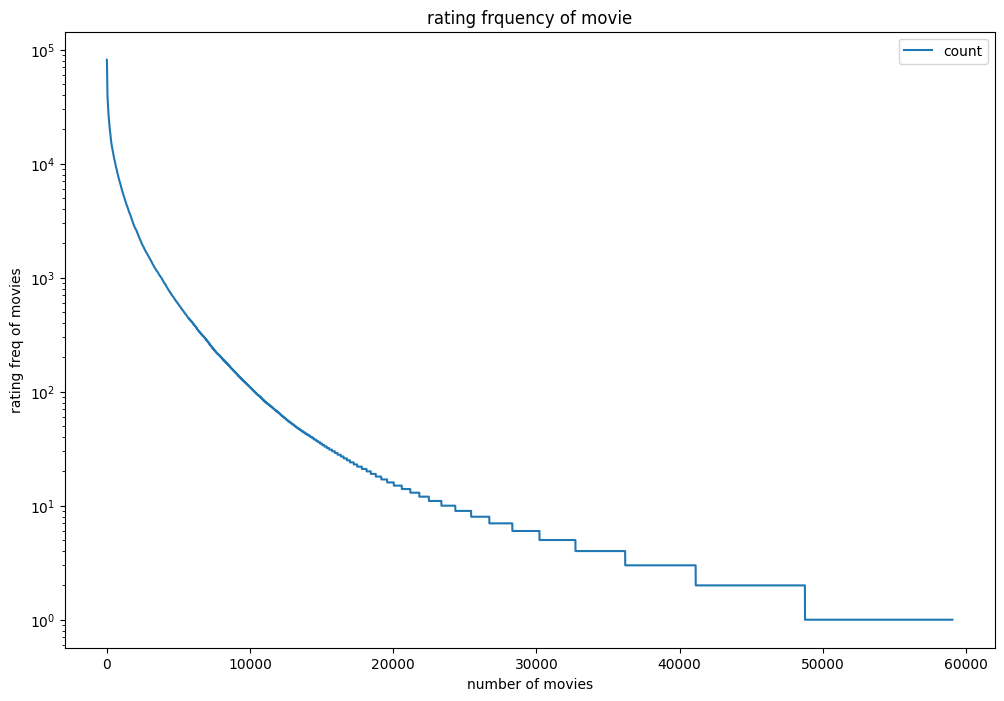

In [60]:
# plot movie rating freq
movie_freq_copy = movie_freq.sort_values(by='count',ascending=False)
movie_freq_copy=movie_freq_copy.reset_index(drop=True)

ax1  = movie_freq_copy.plot(
    title='rating frquency of movie',
    logy=True,
    figsize=(12,8)
)
ax1.set_xlabel('number of movies')
ax1.set_ylabel('rating freq of movies')

In [8]:
# we can see that most of the movies are rated very rarely ..
# so we can remove those movies which are rated less than 50 times.

threshold_rating_freq = 50
# first take out the movie id  for which movie is rated more than threshold value than keep only this movies
#in our original ratings dataframe


popular_movies_id = list(set(movie_freq.query('count>=@threshold_rating_freq').index))

# ratings df after dropping non popular movies
ratings_with_popular_movies = ratings[ratings.movieId.isin(popular_movies_id)]

print('shape of ratings:')
print(ratings.shape)

print('shape of ratings_with_popular_movies:')
print(ratings_with_popular_movies.shape)

print("no of movies which are rated more than 50 times:")
print(len(popular_movies_id))


print("no of unique movies present in dataset:")
print(unique_movie)

shape of ratings:
(169209, 4)
shape of ratings_with_popular_movies:
(97374, 4)
no of movies which are rated more than 50 times:
838
no of unique movies present in dataset:
12243


In [9]:
user_cnt = pd.DataFrame(ratings.groupby('userId').size(),columns=['count'])
user_cnt_copy = user_cnt
user_cnt.head()

,count
userId,
1,70
2,184
3,656
4,242
5,101


from matplotlib import pyplot as plt
_df_23['count'].plot(kind='hist', bins=20, title='count')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_24['count'].plot(kind='line', figsize=(8, 4), title='count')
plt.gca().spines[['top', 'right']].set_visible(False)

Text(0, 0.5, 'rating frequency')

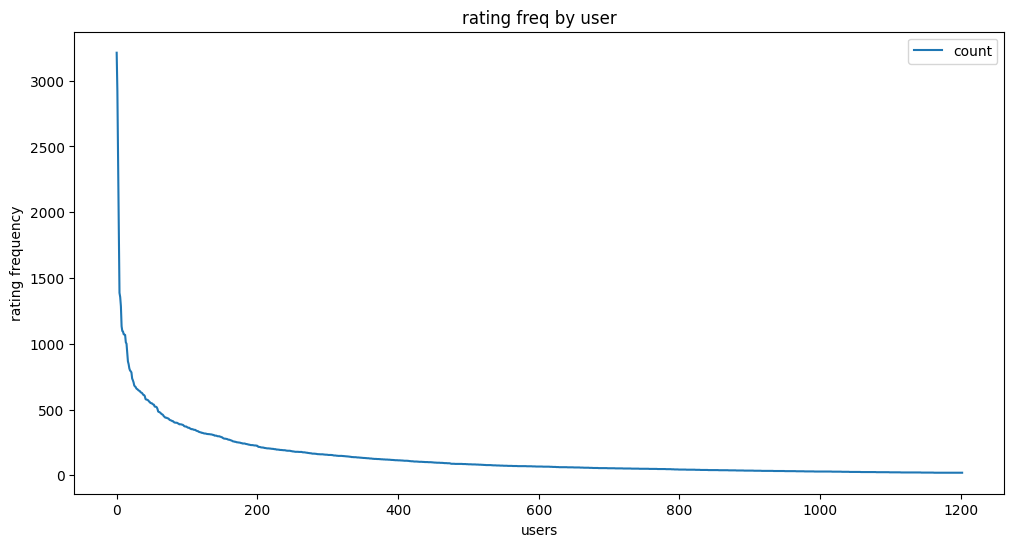

In [10]:
ax  = user_cnt_copy.sort_values('count',ascending=False).reset_index(drop=True).plot(
      title='rating freq by user',
      figsize=(12,6),

)
ax.set_xlabel("users")
ax.set_ylabel("rating frequency")

In [11]:
threshold_val = 30
active_user = list(set(user_cnt.query('count>=@threshold_val').index))

#upadte your ratings_with_popular_movies
ratings_with_popular_movies_with_active_user = ratings_with_popular_movies[ratings_with_popular_movies.userId.isin(active_user)]

print('shape of ratings_with_popular_movies:')
print(ratings_with_popular_movies.shape)

print('shape of ratings_with_popular_movies_with_active_user:')
print(ratings_with_popular_movies_with_active_user.shape)

print("unique_user:")
print(unique_user)

print("active_user")
print(len(active_user))

print("unique_movies")
print(unique_movie)

print("popular_movies")
print(len(popular_movies_id))

shape of ratings_with_popular_movies:
(97374, 4)
shape of ratings_with_popular_movies_with_active_user:
(93521, 4)
unique_user:
1203
active_user
992
unique_movies
12243
popular_movies
838


In [12]:
ratings_with_popular_movies_with_active_user

,userId,movieId,rating,timestamp
0,1,296,5.0,1.147880e+09
1,1,306,3.5,1.147869e+09
4,1,899,3.5,1.147869e+09
5,1,1088,4.0,1.147868e+09
9,1,1250,4.0,1.147868e+09
...,...,...,...,...
169179,1203,51662,4.0,1.421680e+09
169188,1203,53996,4.0,1.421522e+09
169189,1203,54001,4.0,1.421995e+09
169198,1203,56174,2.0,1.421525e+09


from matplotlib import pyplot as plt
ratings_with_popular_movies_with_active_user['userId'].plot(kind='hist', bins=20, title='userId')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
ratings_with_popular_movies_with_active_user['movieId'].plot(kind='hist', bins=20, title='movieId')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
ratings_with_popular_movies_with_active_user['rating'].plot(kind='hist', bins=20, title='rating')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
ratings_with_popular_movies_with_active_user['timestamp'].plot(kind='hist', bins=20, title='timestamp')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
ratings_with_popular_movies_with_active_user.plot(kind='scatter', x='userId', y='movieId', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
ratings_with_popular_movies_with_active_user.plot(kind='scatter', x='movieId', y='rating', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
ratings_with_popular_movies_with_active_user.plot(kind='scatter', x='rating', y='timestamp', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['userId']
  ys = series['movieId']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = ratings_with_popular_movies_with_active_user.sort_values('userId', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('userId')
_ = plt.ylabel('movieId')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['userId']
  ys = series['rating']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = ratings_with_popular_movies_with_active_user.sort_values('userId', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('userId')
_ = plt.ylabel('rating')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['userId']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'userId'}, axis=1)
              .sort_values('userId', ascending=True))
  xs = counted['userId']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = ratings_with_popular_movies_with_active_user.sort_values('userId', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('userId')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['timestamp']
  ys = series['movieId']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = ratings_with_popular_movies_with_active_user.sort_values('timestamp', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('movieId')

from matplotlib import pyplot as plt
ratings_with_popular_movies_with_active_user['userId'].plot(kind='line', figsize=(8, 4), title='userId')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
ratings_with_popular_movies_with_active_user['movieId'].plot(kind='line', figsize=(8, 4), title='movieId')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
ratings_with_popular_movies_with_active_user['rating'].plot(kind='line', figsize=(8, 4), title='rating')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
ratings_with_popular_movies_with_active_user['timestamp'].plot(kind='line', figsize=(8, 4), title='timestamp')
plt.gca().spines[['top', 'right']].set_visible(False)

### **K-Nearest Neighbors (KNN) Model**

In [14]:
movies_users=ratings_with_popular_movies_with_active_user.pivot(index='movieId', columns='userId',values='rating').fillna(0)
mat_movies_users=csr_matrix(movies_users.values)
model_knn= NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20)

### **Training & Evaluating**

In [17]:
model_knn.fit(mat_movies_users)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=20)

In [18]:
def recommender(movie_name, data, model, n_recommendations ):
    model.fit(data)
    idx=process.extractOne(movie_name, movies['title'])[2]
    print('Movie Selected: ',movies['title'][idx], 'Index: ',idx)
    print('Searching for recommendations.....')
    distances, indices=model.kneighbors(data[idx], n_neighbors=n_recommendations)
    for i in indices:
        print(movies['title'][i].where(i!=idx))

recommender('jumanji', mat_movies_users, model_knn,20)

Movie Selected:  Jumanji (1995) Index:  1
Searching for recommendations.....
1                                           NaN
150                       Addiction, The (1995)
106                              Catwalk (1996)
130                                 Jade (1995)
111                     Before and After (1996)
105               Muppet Treasure Island (1996)
158                                Congo (1995)
6                                Sabrina (1995)
102                        Happy Gilmore (1996)
152    Beauty of the Day (Belle de jour) (1967)
85                          White Squall (1996)
134     From the Journals of Jean Seberg (1995)
45         How to Make an American Quilt (1995)
153                       Beyond Rangoon (1995)
51                      Mighty Aphrodite (1995)
86                     Dunston Checks In (1996)
38                              Clueless (1995)
414             Beverly Hillbillies, The (1993)
40                           Richard III (1995)
145        

In [19]:
recommender('Toy Story', mat_movies_users, model_knn,20)

Movie Selected:  Toy Story (1995) Index:  0
Searching for recommendations.....
0                                                    NaN
70                                      Fair Game (1995)
254                                    Just Cause (1995)
286                                      Only You (1994)
102                                 Happy Gilmore (1996)
515                     Robin Hood: Men in Tights (1993)
181                                  Mute Witness (1994)
282                                 Beyond Bedlam (1993)
243                                   Hoop Dreams (1994)
105                        Muppet Treasure Island (1996)
245                                    Houseguest (1994)
80        Things to Do in Denver When You're Dead (1995)
152             Beauty of the Day (Belle de jour) (1967)
130                                          Jade (1995)
342                                   Bitter Moon (1992)
156                                        Casper (1995)
223      

In [20]:
recommender('GoldenEye', mat_movies_users, model_knn,20)

Movie Selected:  GoldenEye (1995) Index:  9
Searching for recommendations.....
9                                                    NaN
190                                      The Show (1995)
5                                            Heat (1995)
27                                     Persuasion (1995)
241                              Gumby: The Movie (1995)
136                               Neon Bible, The (1995)
310                     Secret of Roan Inish, The (1994)
142                        Brothers McMullen, The (1995)
133                                Down Periscope (1996)
137                                        Target (1995)
19                                    Money Train (1995)
103                Bridges of Madison County, The (1995)
170                               Johnny Mnemonic (1995)
14                               Cutthroat Island (1995)
28     City of Lost Children, The (Cité des enfants p...
160                                         Crumb (1994)
161      